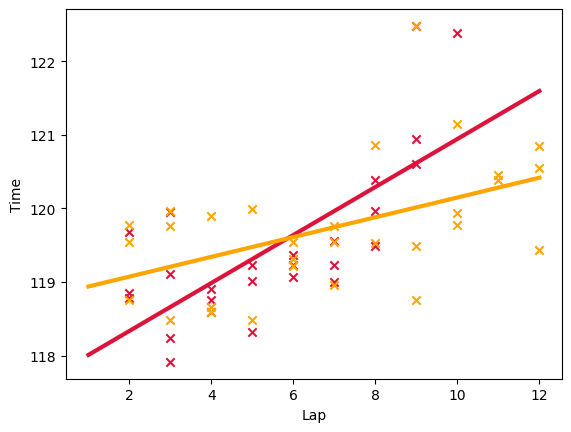

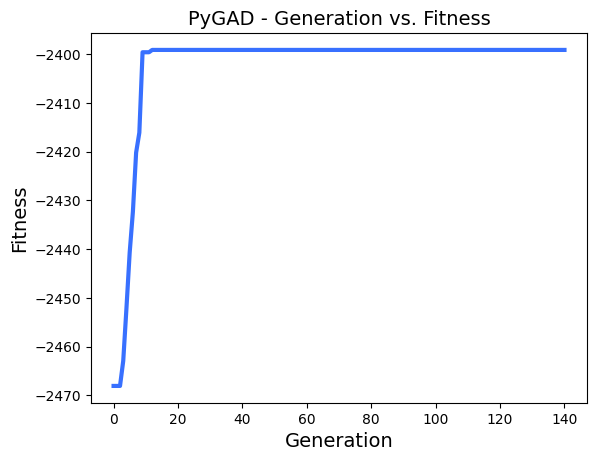

2 [[1, 12], [0, 8]] 2399.1335011841647


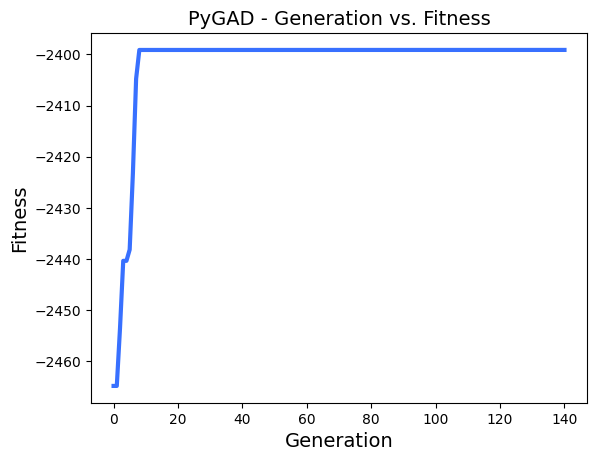

2 [[1, 12], [0, 8]] 2399.1335011841647


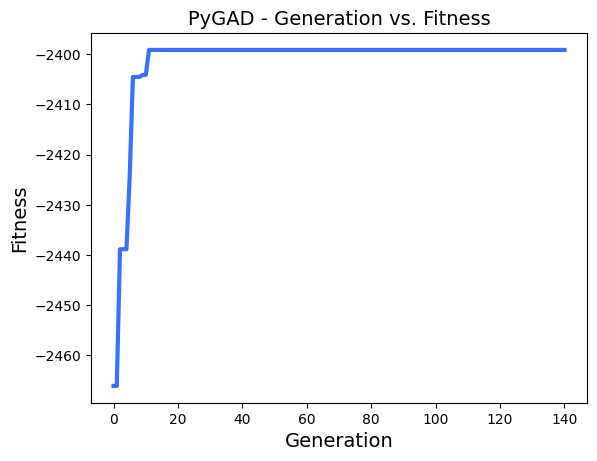

2 [[0, 8], [1, 12]] 2399.1335011841647
done


In [23]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pygad

from simracing.io import parse_lap_times


def _fit_linear_model(lap_data):
    lap_numbers = [[x] for x, _ in lap_data]
    lap_times = [y for _, y in lap_data]
    return LinearRegression().fit(lap_numbers, lap_times)


def _plot_model(lap_times, model, xlimit, color):
    plt.scatter(
        [[x] for x, _ in lap_times],
        [y for _, y in lap_times],
        marker="x",
        color=color
    )

    x = [[i] for i in range(1, xlimit + 1)]
    y = model.predict(x)
    plt.plot(x, y, color=color, linewidth=3)

    plt.xlabel("Lap")
    plt.ylabel("Time")


def _partition_stints(strategy):
    stints = [[strategy[0], 1]]
    for compound in strategy[1:]:
        if compound == -1:  # no tyre change
            stints[-1][1] += 1  # one more lap in current stint
        else:
            stints.append([compound, 1])
    return stints


assert _partition_stints([1, -1, -1, -1, -1, 2, -1, -1, -1, -1]) == [[1, 5], [2, 5]]
assert _partition_stints([1, -1, -1, 1, -1, -1, 1, -1, -1]) == [[1, 3], [1, 3], [1, 3]]
assert _partition_stints([1, 2, 3]) == [[1, 1], [2, 1], [3, 1]]
assert _partition_stints([1, -1, -1]) == [[1, 3]]


def _evaluate_strategy(stints, models, max_stint_length, pit_cost, required_compounds):
    if stints[0][0] == -1:  # must start on some tyres
        return float("inf")
    if any(stint_length > max_stint_length for _, stint_length in stints):
        return float("inf")
    if set(s[0] for s in stints) & required_compounds != required_compounds:
        return float("inf")
    time = 0
    for compound_id, stint_length in stints:
        compound = ("RS", "RM", "RH")[compound_id]
        x = [[i] for i in range(stint_length)]
        stint_time = sum(models[compound].predict(x))
        time += stint_time
    time += (len(stints) - 1) * pit_cost
    return time


def predict_top_strategies(
    *,
    data: str,
    available_compounds: set,
    required_compounds: set,
    lap_count: int,
    max_stint_length: int,
    pit_cost: float
):
    lap_times = parse_lap_times(data)

    models = {
        compound: _fit_linear_model(data)
        for compound, data in lap_times.items()
        if data
    }

    for compound, model in models.items():
        colors = {"RS": "crimson", "RM": "orange", "RH": "dimgray"}
        _plot_model(lap_times[compound], model, max_stint_length, colors[compound])

    def fitness_function(ga_instance, solution, solution_idx):
        stints = _partition_stints(solution)
        # negate result so that the solution is minimized
        return -_evaluate_strategy(stints, models, max_stint_length, pit_cost, required_compounds)

    for i in range(3):
        ga_instance = pygad.GA(
            fitness_func=fitness_function,
            num_genes=lap_count,
            gene_type=int,
            gene_space=[-1, *available_compounds],
            num_generations=512,
            sol_per_pop=512,
            keep_elitism=64,
            stop_criteria="saturate_128",
            parent_selection_type="rank",
            num_parents_mating=8,
            crossover_type="two_points",
            mutation_type="scramble"
        )
        ga_instance.run()

        ga_instance.plot_fitness()
        best = ga_instance.best_solution()
        stints = _partition_stints(best[0])
        print(
            len(stints), 
            stints, 
            _evaluate_strategy(stints, models, max_stint_length, pit_cost, required_compounds)
        )


    return ga_instance, models


RS = 0
RM = 1
RH = 2

# 1. Lago Maggiore
# Tx4; Fx3

data = """
Lap	RS	RM
2	118.849	
3	119.106	
4	118.758	
		
2	119.681	119.777
3	119.949	119.961
4		119.898
5	119.228	
6	119.366	119.225
7	119.554	119.768
8	120.389	119.533
9	120.944	119.490
10		119.782
11		120.388
12		120.556
		
2	118.787	119.546
3	118.237	119.758
4	118.592	118.596
5	118.327	119.996
6	119.066	119.544
7	119.007	119.545
8	119.967	120.864
9	122.480	122.476
10	122.380	119.937
11		120.460
12		120.853
		
2		118.762
3	117.915	118.488
4	118.900	118.663
5	119.009	118.490
6	119.237	119.316
7	119.236	118.959
8	119.486	
9	120.605	118.762
10		121.148
11		
12		119.432
"""

result = predict_top_strategies(
    data=data,
    available_compounds={RS, RM},
    required_compounds={RS, RM},
    lap_count=20,
    max_stint_length=12,
    pit_cost=14,
)

print("done")

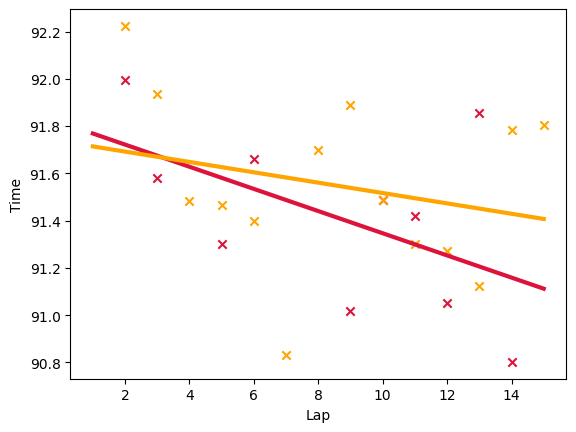

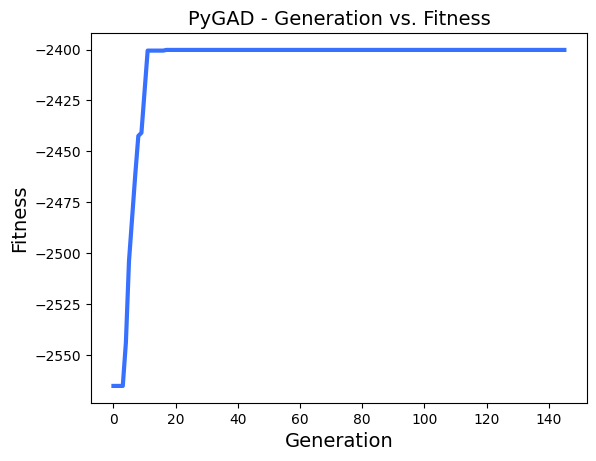

2 [[1, 11], [0, 15]] 2400.1995098901098


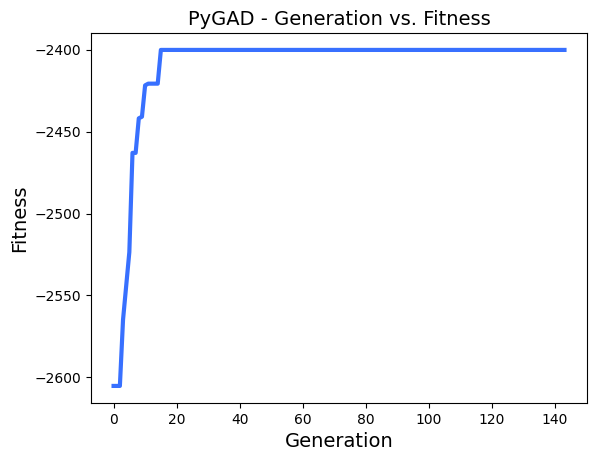

2 [[1, 11], [0, 15]] 2400.1995098901098


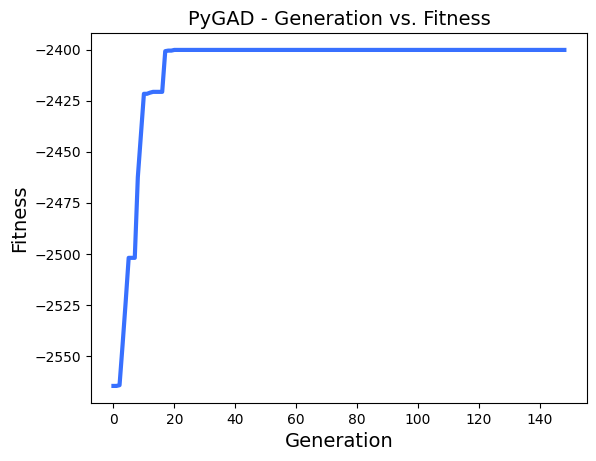

2 [[1, 11], [0, 15]] 2400.1995098901098
done


In [24]:
# 2. Red Bull Ring Tx5 Fx3
data = """
Lap	RS	RM
2	91.994	92.224
3	91.580	91.934
4		91.481
5	91.301	91.465
6	91.660	91.398
7		90.831
8		91.697
9	91.018	91.889
10	91.487	91.489
11	91.420	91.302
12	91.051	91.273
13	91.856	91.124
14	90.802	91.783
15		91.805
"""

result, models = predict_top_strategies(
    data=data,
    available_compounds={RS, RM},
    required_compounds={RS, RM},
    lap_count=26,
    max_stint_length=15,
    pit_cost=20,  # guesstimate
)

print("done")

In [25]:
_evaluate_strategy(((0, 15), (1, 11)), models, 15, 20, {0, 1})

2400.1995098901098

In [26]:
_evaluate_strategy(((0, 11), (1, 15)), models, 15, 20, {0, 1})

2401.130192967033

In [27]:
_evaluate_strategy(((0, 12), (0, 12), (1, 2)), models, 15, 20, {0, 1})

2420.8335925274723